## Importing

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer

# Feature Engineering
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
# Models
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import xgboost as xgb

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Utilities
from sklearn.compose import ColumnTransformer
from collections import Counter
from sklearn.pipeline import Pipeline
from tqdm.auto import tqdm
import joblib


# Combining Datasets

In [2]:
demos = pd.read_csv("/kaggle/input/d/alyhany04/steam-games-analysis/datasets/raw/demos.csv")
dlcs = pd.read_csv("/kaggle/input/d/alyhany04/steam-games-analysis/datasets/raw/dlcs.csv")
gamalytic = pd.read_csv("/kaggle/input/d/alyhany04/steam-games-analysis/datasets/raw/gamalytic_steam_games.csv")
info = pd.read_csv("/kaggle/input/d/alyhany04/steam-games-analysis/datasets/raw/info_base_games.csv", low_memory=False)

demos.columns = demos.columns.str.strip()
dlcs.columns = dlcs.columns.str.strip()
gamalytic.columns = gamalytic.columns.str.strip()
info.columns = info.columns.str.strip()

demos.rename(columns={"full_game_appid": "Full_game_appid"}, inplace=True)
dlcs.rename(columns={"base_appid": "Full_game_appid"}, inplace=True)
gamalytic.rename(columns={"steamId": "Full_game_appid"}, inplace=True)
info.rename(columns={"appid": "Full_game_appid"}, inplace=True)


demos["Full_game_appid"] = demos["Full_game_appid"].astype(str)
dlcs["Full_game_appid"] = dlcs["Full_game_appid"].astype(str)
gamalytic["Full_game_appid"] = gamalytic["Full_game_appid"].astype(str)
info["Full_game_appid"] = info["Full_game_appid"].astype(str)


merged_df = demos.merge(dlcs, on="Full_game_appid", how="inner") \
                 .merge(gamalytic, on="Full_game_appid", how="right") \
                 .merge(info, on="Full_game_appid", how="inner")
merged_df.drop(columns=['Unnamed: 0','demo_appid','dlc_appid','Full_game_appid'], inplace=True)
merged_df.to_csv("/kaggle/working/combined_games.csv", index=False)
print(merged_df.columns)
print("Demos:", demos.shape)
print("DLCs:", dlcs.shape)
print("Gamalytic:", gamalytic.shape)
print("Merged shape:", merged_df.shape)

if 'reviewScore' in merged_df.columns:
      review_score = merged_df.pop('reviewScore')
      merged_df['reviewScore'] = review_score

Index(['name_x', 'name_y', 'price', 'copiesSold', 'publisherClass',
       'reviewScore', 'aiContent', 'name', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'supported_platforms'],
      dtype='object')
Demos: (15449, 4)
DLCs: (5445, 3)
Gamalytic: (93338, 6)
Merged shape: (69428, 16)


In [3]:
  merged_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
0,NaN,NaN,0.0,302158048,AAA,NaN,Counter-Strike 2,NaN,False,True,True,"Action, Free To Play",1.0,"Aug 21, 2012","['windows', 'linux']",87
1,NaN,NaN,0.0,212896574,AAA,NaN,Dota 2,90.0,False,True,True,"Action, Strategy, Free To Play",NaN,"Jul 9, 2013","['windows', 'mac', 'linux']",82
2,NaN,NaN,0.0,161971233,AAA,NaN,PUBG: BATTLEGROUNDS,NaN,False,False,False,"Action, Adventure, Massively Multiplayer, Free...",37.0,"Dec 21, 2017",['windows'],59
3,NaN,NaN,0.0,99060457,AAA,NaN,Team Fortress 2,92.0,True,True,True,"Action, Free To Play",520.0,"Oct 10, 2007","['windows', 'linux']",90
4,NaN,NaN,0.0,67554185,AAA,NaN,Apex Legends™,88.0,True,True,False,"Action, Adventure, Free To Play",12.0,"Nov 4, 2020",['windows'],67


# Data Inspection

In [4]:
df = merged_df
print("Combined shape:", df.shape)
df.info()

Combined shape: (69428, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69428 entries, 0 to 69427
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name_x               520 non-null    object 
 1   name_y               520 non-null    object 
 2   price                69428 non-null  float64
 3   copiesSold           69428 non-null  int64  
 4   publisherClass       69428 non-null  object 
 5   aiContent            0 non-null      float64
 6   name                 69428 non-null  object 
 7   metacritic           2933 non-null   object 
 8   steam_achievements   69428 non-null  bool   
 9   steam_trading_cards  69428 non-null  bool   
 10  workshop_support     69428 non-null  bool   
 11  genres               69324 non-null  object 
 12  achievements_total   37295 non-null  object 
 13  release_date         69426 non-null  object 
 14  supported_platforms  69428 non-null  object 
 15  reviewSc

In [5]:
df.describe()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,price,copiesSold,aiContent,reviewScore
count,69428.000000,6.942800e+04,0.0,69428.000000
mean,7.940826,8.584933e+04,NaN,71.903843
std,15.533680,1.820168e+06,NaN,28.682102
min,0.000000,0.000000e+00,NaN,0.000000
25%,0.990000,6.000000e+01,NaN,60.000000
50%,4.990000,4.570000e+02,NaN,80.000000
75%,9.990000,3.955000e+03,NaN,94.000000
max,1900.000000,3.021580e+08,NaN,100.000000


In [6]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
0,NaN,NaN,0.0,302158048,AAA,NaN,Counter-Strike 2,NaN,False,True,True,"Action, Free To Play",1.0,"Aug 21, 2012","['windows', 'linux']",87
1,NaN,NaN,0.0,212896574,AAA,NaN,Dota 2,90.0,False,True,True,"Action, Strategy, Free To Play",NaN,"Jul 9, 2013","['windows', 'mac', 'linux']",82
2,NaN,NaN,0.0,161971233,AAA,NaN,PUBG: BATTLEGROUNDS,NaN,False,False,False,"Action, Adventure, Massively Multiplayer, Free...",37.0,"Dec 21, 2017",['windows'],59
3,NaN,NaN,0.0,99060457,AAA,NaN,Team Fortress 2,92.0,True,True,True,"Action, Free To Play",520.0,"Oct 10, 2007","['windows', 'linux']",90
4,NaN,NaN,0.0,67554185,AAA,NaN,Apex Legends™,88.0,True,True,False,"Action, Adventure, Free To Play",12.0,"Nov 4, 2020",['windows'],67


In [7]:
df.tail()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
69423,NaN,NaN,4.99,0,Hobbyist,NaN,High Noon,NaN,False,False,False,"Action, Simulation, Early Access",NaN,"Nov 6, 2017",['windows'],0
69424,NaN,NaN,4.99,0,Hobbyist,NaN,Hikaru's Cube,NaN,False,False,False,"Action, Casual, Indie, Early Access",NaN,"Sep 15, 2017",['windows'],0
69425,NaN,NaN,0.99,0,Hobbyist,NaN,Bees Knees,NaN,True,False,False,"Action, Casual, Indie",11,"Sep 4, 2017",['windows'],0
69426,NaN,NaN,0.99,0,Hobbyist,NaN,Brain Crush,NaN,False,False,False,Indie,NaN,"Aug 18, 2017",['windows'],0
69427,NaN,NaN,4.99,0,Hobbyist,NaN,DUNGEON WALK3－奇妙な狂闘－,NaN,True,False,False,Indie,2.0,"Jan 26, 2025",['windows'],0


In [8]:
df.isna().sum()

name_x                 68908
name_y                 68908
price                      0
copiesSold                 0
publisherClass             0
aiContent              69428
name                       0
metacritic             66495
steam_achievements         0
steam_trading_cards        0
workshop_support           0
genres                   104
achievements_total     32133
release_date               2
supported_platforms        0
reviewScore                0
dtype: int64

In [9]:
df.isnull().sum()

name_x                 68908
name_y                 68908
price                      0
copiesSold                 0
publisherClass             0
aiContent              69428
name                       0
metacritic             66495
steam_achievements         0
steam_trading_cards        0
workshop_support           0
genres                   104
achievements_total     32133
release_date               2
supported_platforms        0
reviewScore                0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
print("\n=== Detailed Column Analysis ===")

print("\n1. Metacritic Analysis:")
print("Missing values:", df['metacritic'].isna().sum())
print("Percentage missing:", (df['metacritic'].isna().sum() / len(df)) * 100)

df['metacritic'] = pd.to_numeric(df['metacritic'], errors='coerce')
if 'reviewScore' in df.columns:
    df['reviewScore'] = pd.to_numeric(df['reviewScore'], errors='coerce')
    
    print("\nCorrelation with reviewScore:", df['metacritic'].corr(df['reviewScore']))

print("\nMetacritic statistics:")
print(df['metacritic'].describe())

print("\n2. Achievements Analysis:")

df['achievements_total'] = pd.to_numeric(df['achievements_total'], errors='coerce')

print("Missing values:", df['achievements_total'].isna().sum())
print("Percentage missing:", (df['achievements_total'].isna().sum() / len(df)) * 100)

print("\nGames with achievements:")
print(df[df['achievements_total'] > 0]['achievements_total'].describe())

if 'reviewScore' in df.columns:
    print("\nCorrelation with reviewScore:", df['achievements_total'].corr(df['reviewScore']))

print("\n3. Genres Analysis:")
print("Missing values:", df['genres'].isna().sum())
print("Percentage missing:", (df['genres'].isna().sum() / len(df)) * 100)
print("\nTop 10 most common genres:")
print(df['genres'].value_counts().head(10))

print("\n4. Release Date Analysis:")
print("Missing values:", df['release_date'].isna().sum())
print("Percentage missing:", (df['release_date'].isna().sum() / len(df)) * 100)
print("\nRelease date distribution:")
print(df['release_date'].value_counts().head())

print("\n5. High Missing Value Columns Analysis:")
columns_to_check = ['aiContent','name_x', 'name_y']
for col in columns_to_check:
    print(f"\n{col} missing values:", df[col].isna().sum())
    print(f"Percentage missing:", (df[col].isna().sum() / len(df)) * 100)

print("\n6. Duplicate Analysis:")
print("Number of duplicate rows:", df.duplicated().sum())
print("\nSample of duplicate rows:")
df[df.duplicated()].head()


=== Detailed Column Analysis ===

1. Metacritic Analysis:
Missing values: 66495
Percentage missing: 95.77547963357723

Correlation with reviewScore: 0.5858480322388269

Metacritic statistics:
count    2933.000000
mean       73.669622
std        10.233509
min        20.000000
25%        68.000000
50%        75.000000
75%        81.000000
max        97.000000
Name: metacritic, dtype: float64

2. Achievements Analysis:
Missing values: 32133
Percentage missing: 46.28247969119087

Games with achievements:
count    36585.000000
mean        40.287003
std        241.426147
min          1.000000
25%         10.000000
50%         18.000000
75%         33.000000
max       5394.000000
Name: achievements_total, dtype: float64

Correlation with reviewScore: -0.012176039783700436

3. Genres Analysis:
Missing values: 104
Percentage missing: 0.1497954715676672

Top 10 most common genres:
genres
Casual, Indie               4139
Action, Indie               3470
Action, Adventure, Indie    3164
Adventure

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore


## Detailed Column Analysis for Preprocessing Decisions

# EDA

### Univariate Analysis

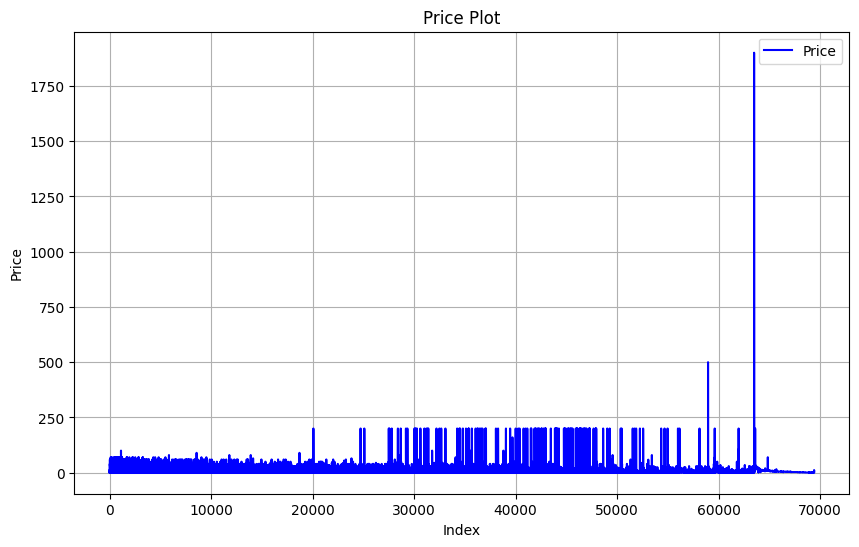

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df['price'], label='Price', color='blue')
plt.title('Price Plot')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

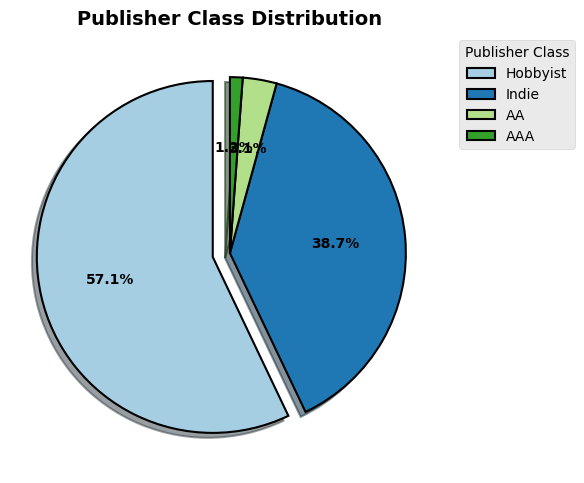

In [13]:
plt.style.use("ggplot")
publisher_class_counts = df['publisherClass'].value_counts()
explode = [0.1 if i == 0 else 0 for i in range(len(publisher_class_counts))]

plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(
    publisher_class_counts,
    labels=None,  
    autopct='%1.1f%%', 
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

plt.legend(patches, publisher_class_counts.index, loc='upper right', bbox_to_anchor=(1.3, 1), title="Publisher Class")
plt.title('Publisher Class Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
df['reviewScore'].value_counts()

reviewScore
100    12014
0       5665
50      2225
67      2105
75      1767
       ...  
7          6
6          5
5          5
2          2
4          1
Name: count, Length: 99, dtype: int64

In [15]:
df['price'].value_counts()

price
0.00     10398
4.99      8047
0.99      7058
9.99      6912
1.99      5270
         ...  
5.28         1
4.33         1
2.84         1
13.37        1
4.45         1
Name: count, Length: 295, dtype: int64

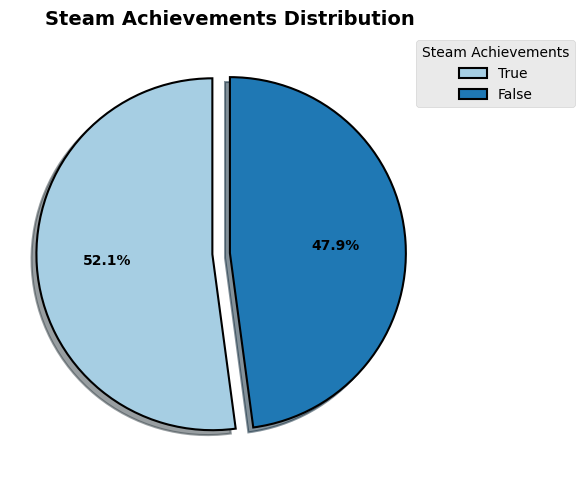

In [16]:
steam_achievements_counts = df['steam_achievements'].value_counts()
plt.style.use("ggplot")
explode = [0.1 if i == 0 else 0 for i in range(len(steam_achievements_counts))]
plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(
    steam_achievements_counts,
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

plt.legend(
    patches,
    steam_achievements_counts.index,
    loc='upper right',
    bbox_to_anchor=(1.3, 1),
    title="Steam Achievements"
)


plt.title('Steam Achievements Distribution', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

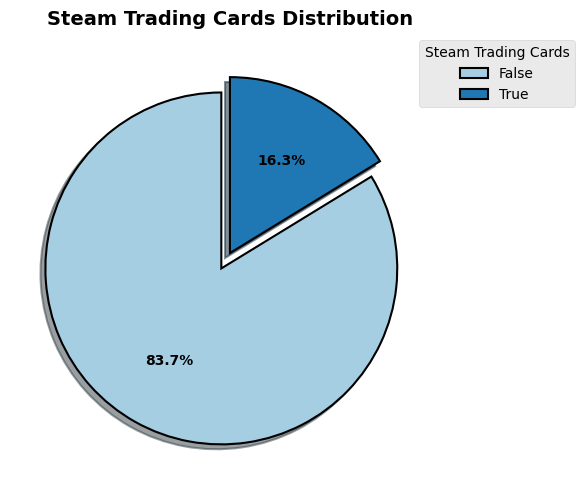

In [17]:
steam_trading_cards_counts = df['steam_trading_cards'].value_counts()
plt.style.use("ggplot")
explode = [0.1 if i == 0 else 0 for i in range(len(steam_trading_cards_counts))]
plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(
    steam_trading_cards_counts,
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

plt.legend(
    patches,
    steam_trading_cards_counts.index,
    loc='upper right',
    bbox_to_anchor=(1.3, 1),
    title="Steam Trading Cards"
)


plt.title('Steam Trading Cards Distribution', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

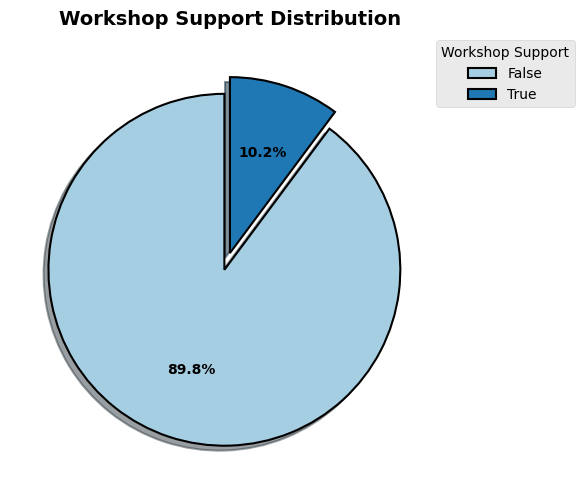

In [18]:
workshop_support_counts = df['workshop_support'].value_counts()
plt.style.use("ggplot")
explode = [0.1 if i == 0 else 0 for i in range(len(workshop_support_counts))]
plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(
    workshop_support_counts,
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

plt.legend(
    patches,
    workshop_support_counts.index,
    loc='upper right',
    bbox_to_anchor=(1.3, 1),
    title="Workshop Support"
)


plt.title('Workshop Support Distribution', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

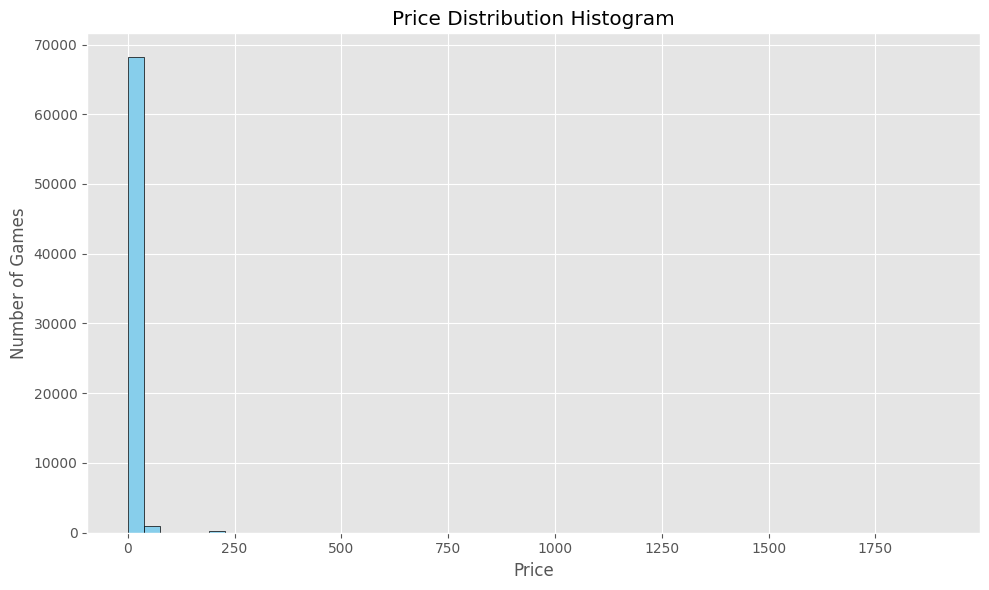

In [19]:
price_counts = df['price'].value_counts().sort_index()
expanded_prices = np.repeat(price_counts.index, price_counts.values)
plt.figure(figsize=(10, 6))
plt.hist(expanded_prices, bins=50, color='skyblue', edgecolor='black')
plt.title('Price Distribution Histogram')
plt.xlabel('Price')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

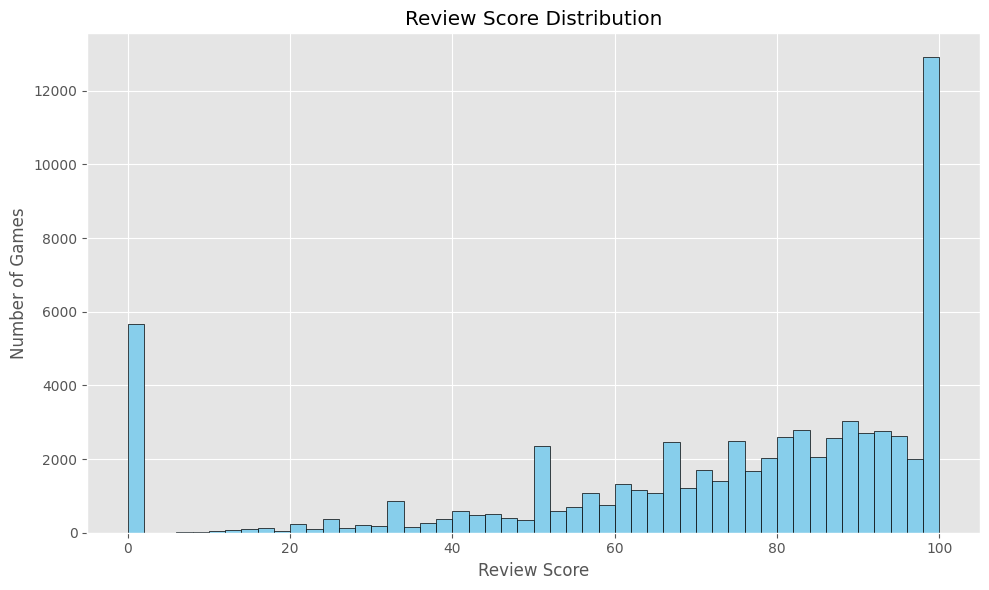

In [20]:
review_score_counts = df['reviewScore'].value_counts().sort_index()
expanded_review_scores = np.repeat(review_score_counts.index, review_score_counts.values)
plt.figure(figsize=(10, 6))
plt.hist(expanded_review_scores, bins=50, color='skyblue', edgecolor='black')  
plt.title('Review Score Distribution')
plt.xlabel('Review Score')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

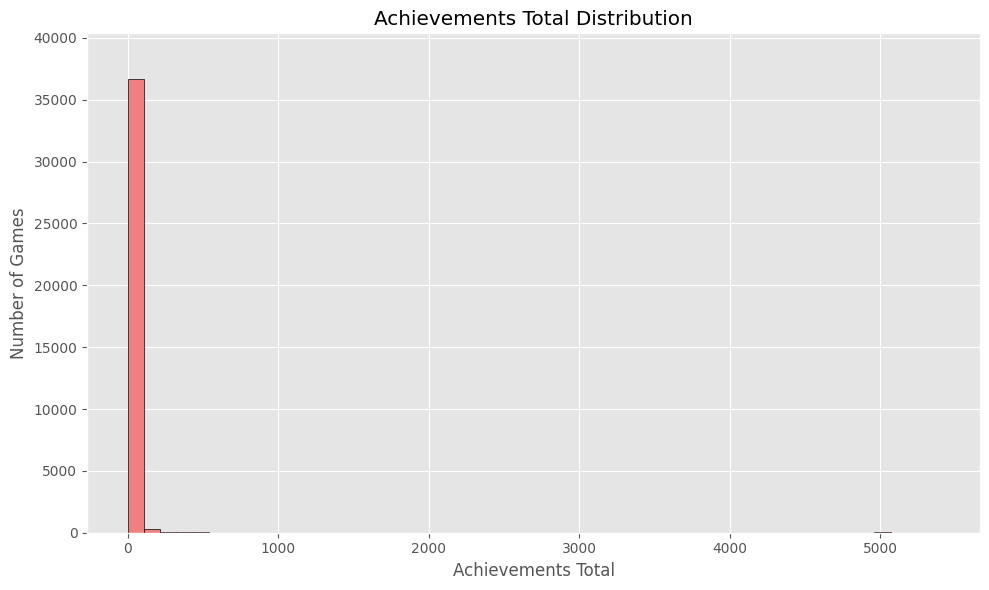

In [21]:
achievements_counts = df['achievements_total'].value_counts().sort_index()
expanded_achievements = np.repeat(achievements_counts.index, achievements_counts.values)
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(expanded_achievements, bins=50, color='lightcoral', edgecolor='black')
plt.title('Achievements Total Distribution')
plt.xlabel('Achievements Total')
plt.ylabel('Number of Games')
plt.ylim(0, max(n) + (max(n) * 0.1))
plt.grid(True)
plt.tight_layout()
plt.show()


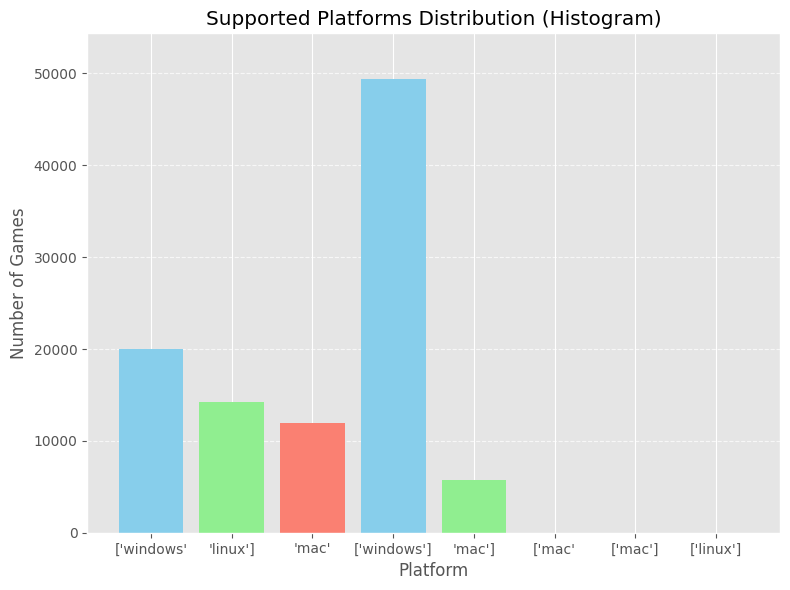

In [22]:
platform_list = []

for platforms in df['supported_platforms']:
    if isinstance(platforms, str):  
        platforms = platforms.lower().split(',')
        platform_list.extend([platform.strip() for platform in platforms])


platform_counts = Counter(platform_list)


plt.figure(figsize=(8, 6))
plt.bar(platform_counts.keys(), platform_counts.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Supported Platforms Distribution (Histogram)')
plt.xlabel('Platform')
plt.ylabel('Number of Games')


max_count = max(platform_counts.values())
plt.ylim(0, max_count + (max_count * 0.1))

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

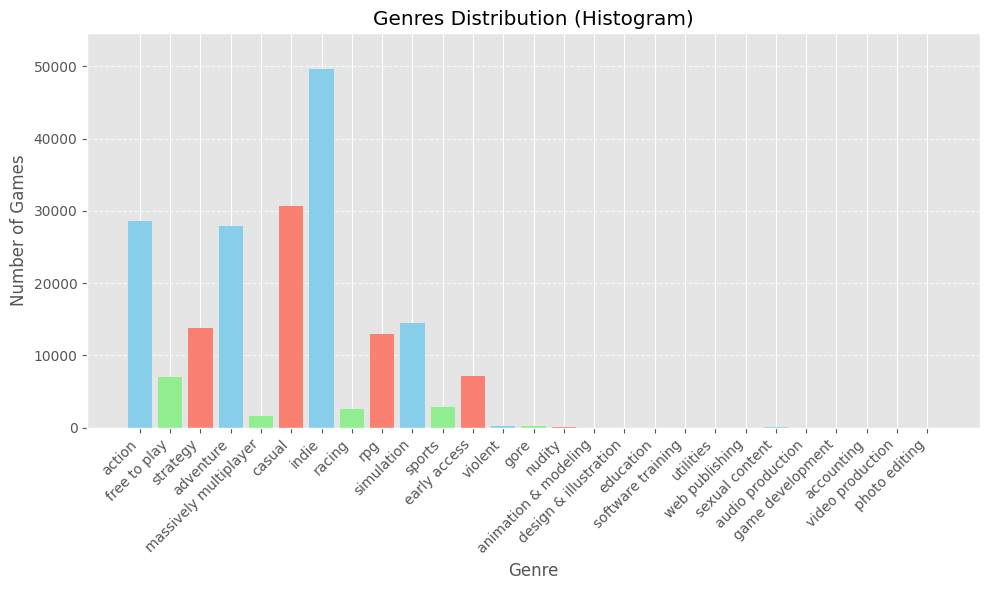

In [23]:
genres_list = []
for genres in df['genres']:
    if isinstance(genres, str): 
        genres = genres.lower().split(',')
        genres_list.extend([genre.strip() for genre in genres])


genres_counts = Counter(genres_list)


plt.figure(figsize=(10, 6))
plt.bar(genres_counts.keys(), genres_counts.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Genres Distribution (Histogram)')
plt.xlabel('Genre')
plt.ylabel('Number of Games')

max_count = max(genres_counts.values())
plt.ylim(0, max_count + (max_count * 0.1)) 

plt.xticks(rotation=45, ha="right") 
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Bivariate Analysis

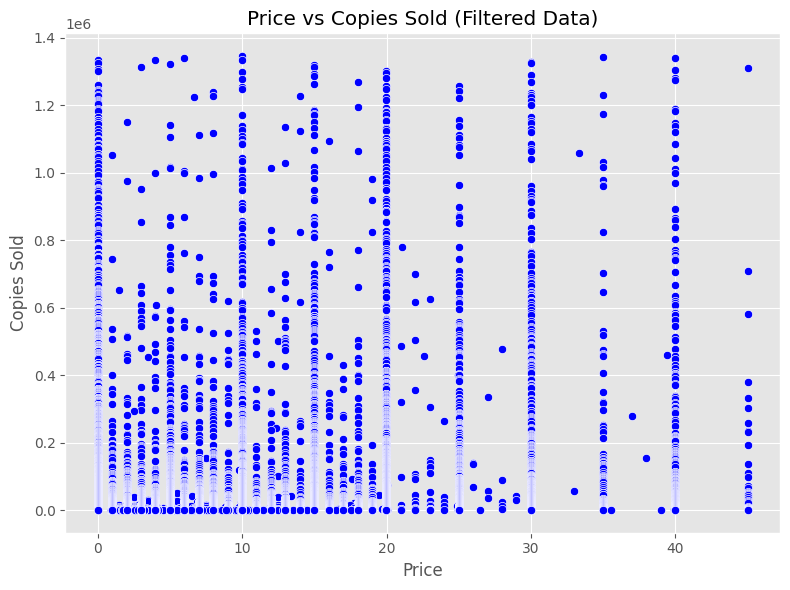

In [24]:
price_threshold = df['price'].quantile(0.99)  
copiesSold_threshold = df['copiesSold'].quantile(0.99)  

filtered_df = df[(df['price'] <= price_threshold) & (df['copiesSold'] <= copiesSold_threshold)]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='price', y='copiesSold', data=filtered_df, color='blue')
plt.title('Price vs Copies Sold (Filtered Data)')
plt.xlabel('Price')
plt.ylabel('Copies Sold')
plt.grid(True)
plt.tight_layout()
plt.show()

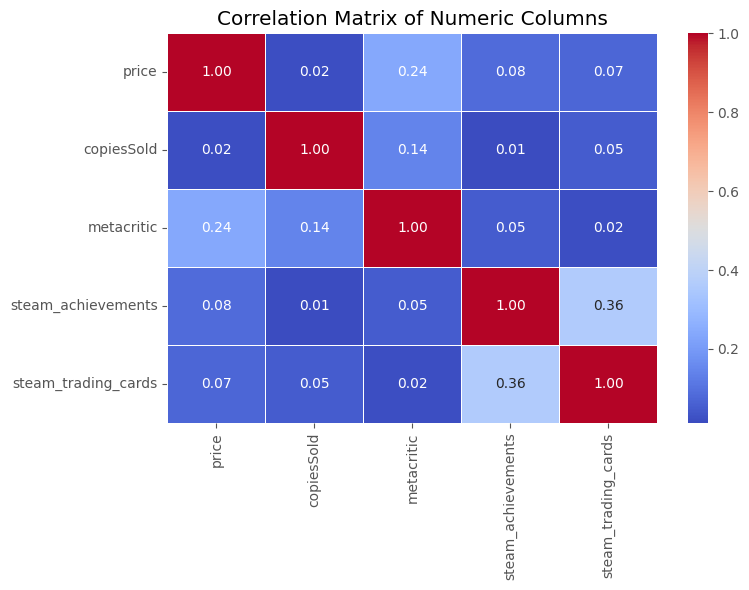

In [25]:
numeric_columns = ['price', 'copiesSold', 'metacritic', 'steam_achievements', 'steam_trading_cards']
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Columns')
plt.tight_layout()
plt.show()

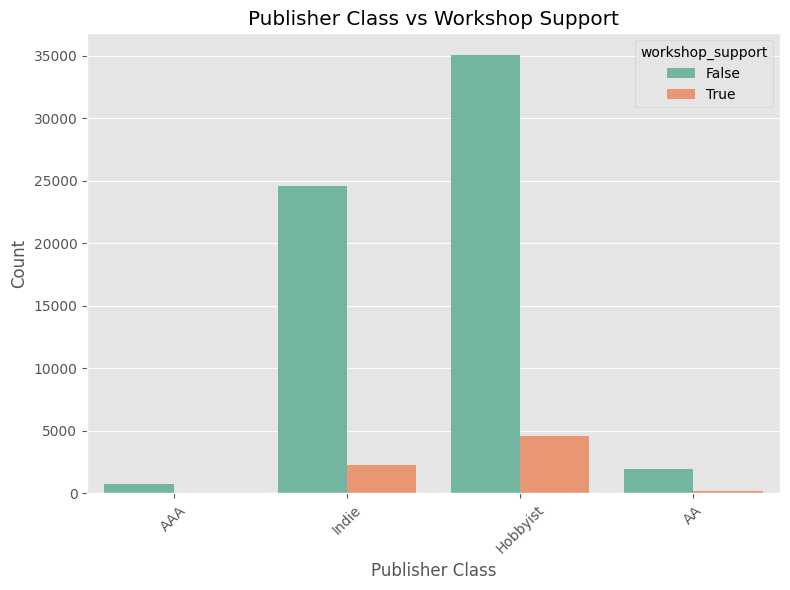

In [26]:
plt.figure(figsize=(8, 6))
sns.countplot(x='publisherClass', hue='workshop_support', data=df, palette='Set2')
plt.title('Publisher Class vs Workshop Support')
plt.xlabel('Publisher Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Additional Visualizations for Preprocessing Decisions

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


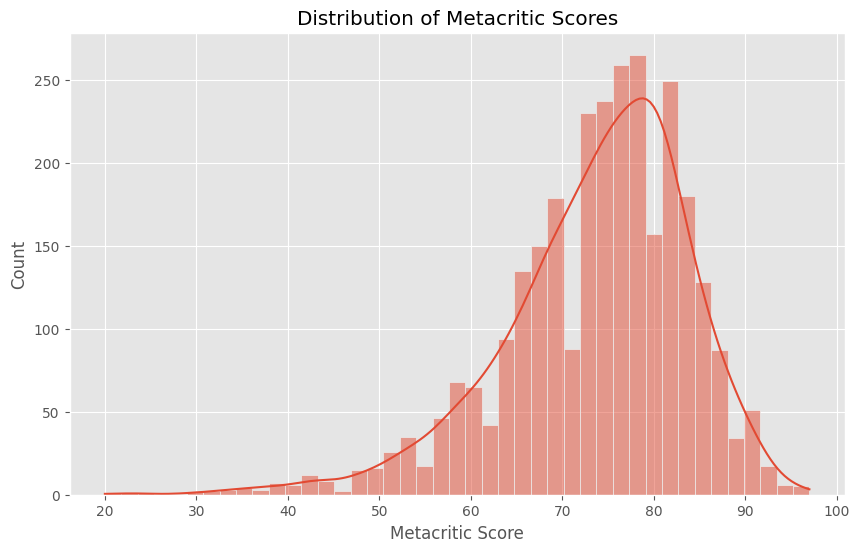

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(df['metacritic'].dropna(), kde=True)
plt.title('Distribution of Metacritic Scores')
plt.xlabel('Metacritic Score')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


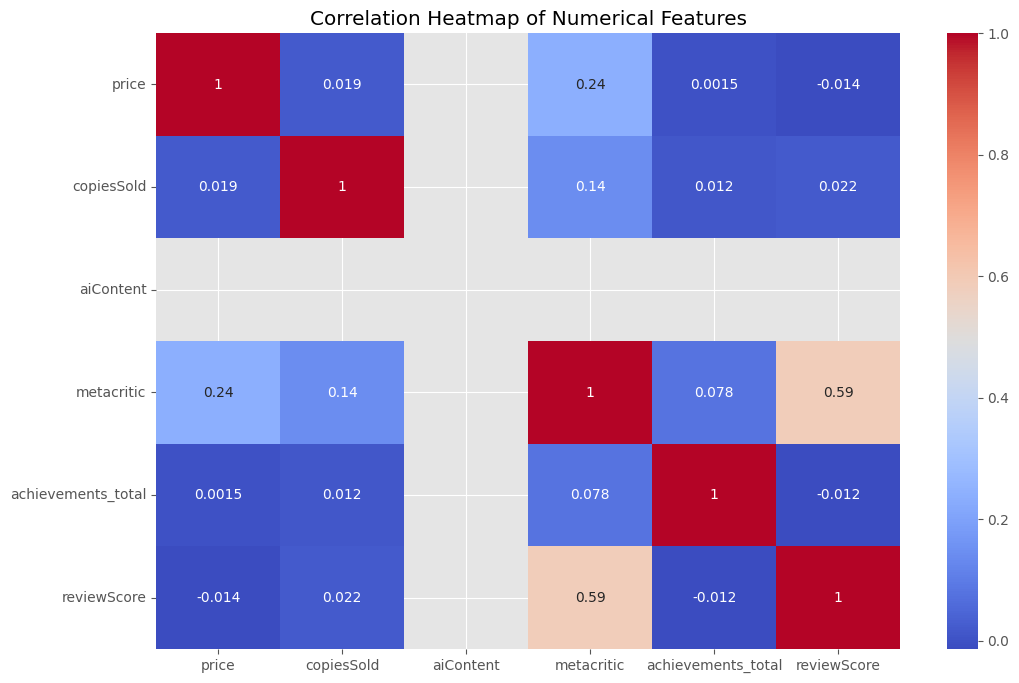

In [28]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Preprocessing

## Data Cleaning


## Outliers

In [29]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    df.loc[outliers, col] = df[col].mean()
df.head()

/tmp/ipykernel_14/3648659883.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '85849.32674137235' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, col] = df[col].mean()
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/tmp/ipykernel_14/3648659883.py:9: FutureWarning: Setting an item of incompatib

,name_x,name_y,price,copiesSold,publisherClass,aiContent,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms,reviewScore
0,NaN,NaN,0.0,85849.326741,AAA,NaN,Counter-Strike 2,NaN,False,True,True,"Action, Free To Play",1.000000,"Aug 21, 2012","['windows', 'linux']",87.0
1,NaN,NaN,0.0,85849.326741,AAA,NaN,Dota 2,90.0,False,True,True,"Action, Strategy, Free To Play",NaN,"Jul 9, 2013","['windows', 'mac', 'linux']",82.0
2,NaN,NaN,0.0,85849.326741,AAA,NaN,PUBG: BATTLEGROUNDS,NaN,False,False,False,"Action, Adventure, Massively Multiplayer, Free...",37.000000,"Dec 21, 2017",['windows'],59.0
3,NaN,NaN,0.0,85849.326741,AAA,NaN,Team Fortress 2,92.0,True,True,True,"Action, Free To Play",39.520043,"Oct 10, 2007","['windows', 'linux']",90.0
4,NaN,NaN,0.0,85849.326741,AAA,NaN,Apex Legends™,88.0,True,True,False,"Action, Adventure, Free To Play",12.000000,"Nov 4, 2020",['windows'],67.0


## Name

In [30]:
df['achievements_total'] = df['achievements_total'].fillna(0)
df['genres'] = df['genres'].fillna(df['genres'].mode()[0])
print(df.columns)
df = df.dropna(subset=['release_date'])
columns_to_drop = ['metacritic']
df = df.drop(columns=columns_to_drop)
df = df.drop_duplicates()
print("Shape after Previous preprocessing:", df.shape)
print("\nMissing values after preprocessing:")
print(df.isna().sum())

Index(['name_x', 'name_y', 'price', 'copiesSold', 'publisherClass',
       'aiContent', 'name', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'supported_platforms',
       'reviewScore'],
      dtype='object')
Shape after Previous preprocessing: (69426, 15)

Missing values after preprocessing:
name_x                 68906
name_y                 68906
price                      0
copiesSold                 0
publisherClass             0
aiContent              69426
name                       0
steam_achievements         0
steam_trading_cards        0
workshop_support           0
genres                     0
achievements_total         0
release_date               0
supported_platforms        0
reviewScore                0
dtype: int64


In [31]:
df['name'] = df['name'].fillna('Unknown Game') 
df['name'] = df['name'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df['name'] = df['name'].str.lower()
df['name'] = df['name'].str.strip()
df['name_tokens'] = df['name'].str.split()
df['name_length'] = df['name'].apply(len)
df[['name', 'name_tokens', 'name_length']].head()


,name,name_tokens,name_length
0,counterstrike 2,"[counterstrike, 2]",15
1,dota 2,"[dota, 2]",6
2,pubg battlegrounds,"[pubg, battlegrounds]",18
3,team fortress 2,"[team, fortress, 2]",15
4,apex legends,"[apex, legends]",12


## Date

Missing values in 'year': 0
Missing values in 'day': 0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


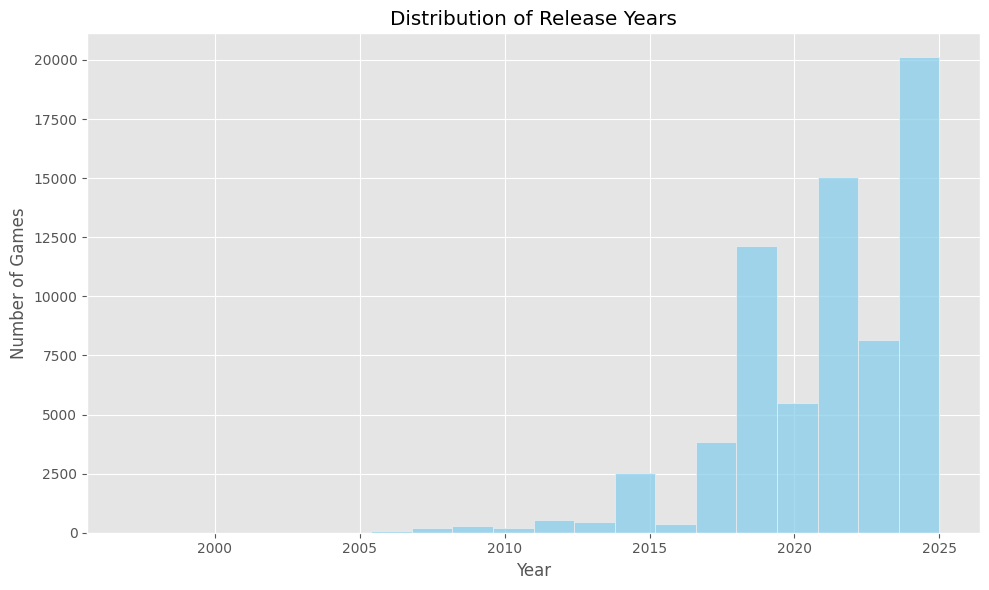

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


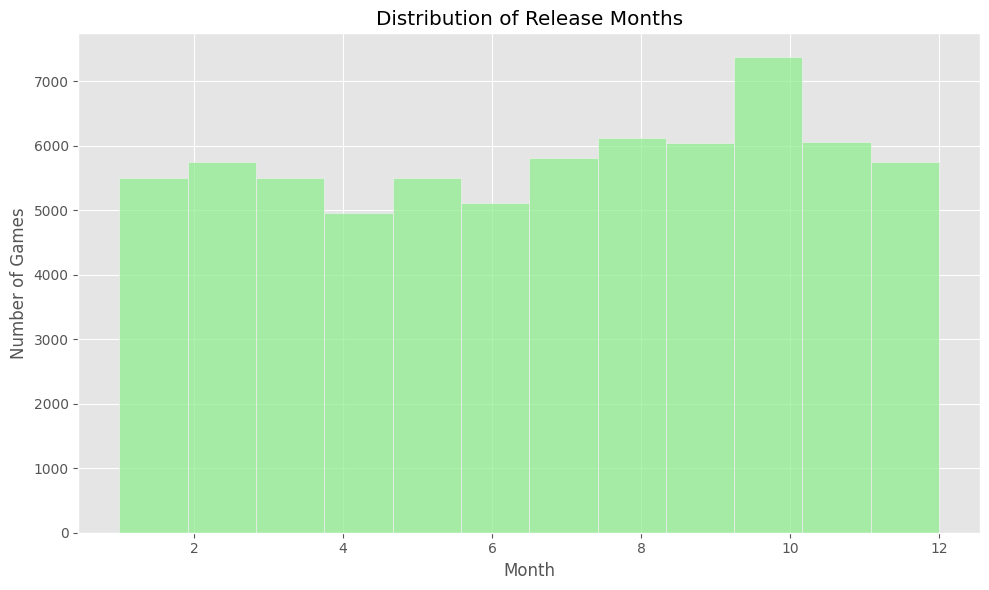

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


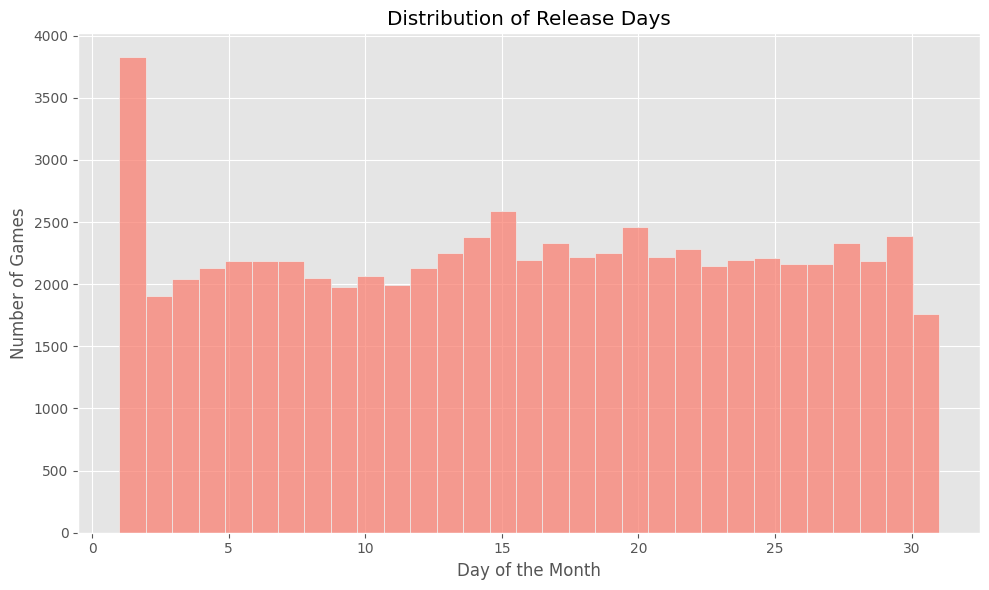

In [32]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['year'] = df['release_date'].dt.year  
df['month'] = df['release_date'].dt.month  
df['day'] = df['release_date'].dt.day 

df['year'] = df['year'].fillna(df['year'].mode()[0])
df['day'] = df['day'].fillna(df['day'].mode()[0])
df['month'] = df['month'].fillna(df['month'].mode()[0])


print(f"Missing values in 'year': {df['year'].isnull().sum()}")
print(f"Missing values in 'day': {df['day'].isnull().sum()}")


df = df.drop('release_date', axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(df['year'], kde=False, bins=20, color='skyblue')
plt.title('Distribution of Release Years')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['month'], kde=False, bins=12, color='lightgreen')
plt.title('Distribution of Release Months')
plt.xlabel('Month')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['day'], kde=False, bins=31, color='salmon')
plt.title('Distribution of Release Days')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()


## Encoding

### Boolean Features 

In [33]:
 bool_features = ['steam_achievements', 'steam_trading_cards', 'workshop_support']
for feature in bool_features:
    df[feature] = df[feature].astype(int)

### Publisher Class 

In [34]:
label_encoder = LabelEncoder()
df['publisher_class_encoded'] = label_encoder.fit_transform(df['publisherClass'])
df[['publisherClass', 'publisher_class_encoded']].head()
df.drop(columns='publisherClass',inplace=True)
print(df.columns)

Index(['name_x', 'name_y', 'price', 'copiesSold', 'aiContent', 'name',
       'steam_achievements', 'steam_trading_cards', 'workshop_support',
       'genres', 'achievements_total', 'supported_platforms', 'reviewScore',
       'name_tokens', 'name_length', 'year', 'month', 'day',
       'publisher_class_encoded'],
      dtype='object')


### Genres

In [35]:
genres = df['genres'].str.split(',', expand=True)
genre_columns = []

unique_genres = pd.unique(genres.values.ravel())

for genre in unique_genres:
    df[genre] = genres.apply(lambda row: 1 if genre in row.values else 0, axis=1)
    genre_columns.append(genre)

df = df.drop('genres', axis=1)

df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Nudity,Audio Production,Game Development,Early Access,Accounting,Video Production,Education,Animation & Modeling,Photo Editing,Design & Illustration
0,NaN,NaN,0.0,85849.326741,NaN,counterstrike 2,0,1,1,1.000000,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,0.0,85849.326741,NaN,dota 2,0,1,1,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,0.0,85849.326741,NaN,pubg battlegrounds,0,0,0,37.000000,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,0.0,85849.326741,NaN,team fortress 2,1,1,1,39.520043,...,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,0.0,85849.326741,NaN,apex legends,1,1,0,12.000000,...,0,0,0,0,0,0,0,0,0,0


### Supported Platforms

In [36]:
platforms = df['supported_platforms'].str.split(',', expand=True)

df['windows'] = platforms[0].apply(lambda x: 1 if pd.notna(x) and 'windows' in x.lower() else 0)
df['linux'] = platforms[1].apply(lambda x: 1 if pd.notna(x) and 'linux' in x.lower() else 0)
df['mac'] = platforms[2].apply(lambda x: 1 if pd.notna(x) and 'mac' in x.lower() else 0)

df = df.drop('supported_platforms', axis=1)


df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Early Access,Accounting,Video Production,Education,Animation & Modeling,Photo Editing,Design & Illustration,windows,linux,mac
0,NaN,NaN,0.0,85849.326741,NaN,counterstrike 2,0,1,1,1.000000,...,0,0,0,0,0,0,0,1,1,0
1,NaN,NaN,0.0,85849.326741,NaN,dota 2,0,1,1,0.000000,...,0,0,0,0,0,0,0,1,0,0
2,NaN,NaN,0.0,85849.326741,NaN,pubg battlegrounds,0,0,0,37.000000,...,0,0,0,0,0,0,0,1,0,0
3,NaN,NaN,0.0,85849.326741,NaN,team fortress 2,1,1,1,39.520043,...,0,0,0,0,0,0,0,1,1,0
4,NaN,NaN,0.0,85849.326741,NaN,apex legends,1,1,0,12.000000,...,0,0,0,0,0,0,0,1,0,0


## Scaling

In [37]:
columns_to_scale = [col for col in numeric_columns if col not in genre_columns]
columns_to_scale.remove('metacritic')

X_numeric = df[columns_to_scale]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
y = df['reviewScore']

X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns)

X_final = pd.concat([X_scaled_df, df[genre_columns]], axis=1)


df_scaled = pd.concat([X_final, y], axis=1)


df_scaled.head()
df[df_scaled.columns] = df_scaled

In [38]:
df_scaled.describe()

,price,copiesSold,steam_achievements,steam_trading_cards,Action,Free To Play,None,Strategy,Adventure,Massively Multiplayer,...,Audio Production,Game Development,Early Access,Accounting,Video Production,Education,Animation & Modeling,Photo Editing,Design & Illustration,reviewScore
count,6.942600e+04,6.942600e+04,6.942600e+04,6.942600e+04,69426.000000,69426.00000,69426.000000,69426.000000,69426.000000,69426.000000,...,69426.000000,69426.000000,69426.000000,69426.000000,69426.000000,69426.000000,69426.000000,69426.000000,69426.000000,69426.000000
mean,-1.310020e-16,-5.240081e-17,5.240081e-17,6.550102e-18,0.408017,0.09446,0.999928,0.184729,0.188633,0.021534,...,0.000101,0.000245,0.000230,0.000043,0.000043,0.000058,0.000029,0.000014,0.000014,77.800798
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,0.491470,0.29247,0.008486,0.388080,0.391219,0.145156,...,0.010041,0.015646,0.015179,0.006573,0.006573,0.007590,0.005367,0.003795,0.003795,19.080266
min,-1.114701e+00,-4.910808e-01,-1.043283e+00,-4.405878e-01,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
25%,-9.314037e-01,-4.892099e-01,-1.043283e+00,-4.405878e-01,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.000000
50%,-1.908092e-01,-4.768310e-01,9.585126e-01,-4.405878e-01,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000
75%,7.349339e-01,-3.677668e-01,9.585126e-01,-4.405878e-01,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
max,3.143718e+00,2.185808e+00,9.585126e-01,2.269695e+00,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [39]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Early Access,Accounting,Video Production,Education,Animation & Modeling,Photo Editing,Design & Illustration,windows,linux,mac
0,NaN,NaN,-1.114701,2.185808,NaN,counterstrike 2,-1.043283,2.269695,1,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
1,NaN,NaN,-1.114701,2.185808,NaN,dota 2,-1.043283,2.269695,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2,NaN,NaN,-1.114701,2.185808,NaN,pubg battlegrounds,-1.043283,-0.440588,0,37.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,NaN,NaN,-1.114701,2.185808,NaN,team fortress 2,0.958513,2.269695,1,39.520043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
4,NaN,NaN,-1.114701,2.185808,NaN,apex legends,0.958513,2.269695,0,12.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


# Feature Engineering and Selection

## Total genres Feature

In [40]:
df['Total_Genres'] = df[genre_columns].sum(axis=1)
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name_x,name_y,price,copiesSold,aiContent,name,steam_achievements,steam_trading_cards,workshop_support,achievements_total,...,Accounting,Video Production,Education,Animation & Modeling,Photo Editing,Design & Illustration,windows,linux,mac,Total_Genres
0,NaN,NaN,-1.114701,2.185808,NaN,counterstrike 2,-1.043283,2.269695,1,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,3.0
1,NaN,NaN,-1.114701,2.185808,NaN,dota 2,-1.043283,2.269695,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,4.0
2,NaN,NaN,-1.114701,2.185808,NaN,pubg battlegrounds,-1.043283,-0.440588,0,37.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,5.0
3,NaN,NaN,-1.114701,2.185808,NaN,team fortress 2,0.958513,2.269695,1,39.520043,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,3.0
4,NaN,NaN,-1.114701,2.185808,NaN,apex legends,0.958513,2.269695,0,12.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,4.0


In [41]:
zero_genres = (df['Total_Genres']==0).sum()
print(zero_genres)

0


## Number of Platforms Feature

In [42]:
platforms_columns = ['windows','linux','mac']
df['Total_Platforms'] = df[platforms_columns].sum(axis=1)

In [43]:
zero_platforms = (df['Total_Platforms']== 0 ).sum()
print(zero_platforms)
df = df[df['Total_Platforms']!=0]
zero_platforms_after = (df['Total_Platforms']== 0 ).sum()
print(zero_platforms_after)

7
0


## Columns With Too much nulls

In [44]:
df.drop(columns=['name_x','name_y','aiContent'],inplace=True)
print(df.columns)

Index([                  'price',              'copiesSold',
                          'name',      'steam_achievements',
           'steam_trading_cards',        'workshop_support',
            'achievements_total',             'reviewScore',
                   'name_tokens',             'name_length',
                          'year',                   'month',
                           'day', 'publisher_class_encoded',
                        'Action',           ' Free To Play',
                            None,               ' Strategy',
                    ' Adventure',  ' Massively Multiplayer',
                       ' Casual',                  ' Indie',
                       ' Racing',                    ' RPG',
                        'Casual',             ' Simulation',
                     'Adventure',                     'RPG',
                       ' Sports',           ' Early Access',
                         'Indie',                'Strategy',
                    'Sim

## Useless features

In [45]:
df.drop(columns=['name','name_tokens','name_length'],inplace=True)
print(df.columns)

Index([                  'price',              'copiesSold',
            'steam_achievements',     'steam_trading_cards',
              'workshop_support',      'achievements_total',
                   'reviewScore',                    'year',
                         'month',                     'day',
       'publisher_class_encoded',                  'Action',
                 ' Free To Play',                      None,
                     ' Strategy',              ' Adventure',
        ' Massively Multiplayer',                 ' Casual',
                        ' Indie',                 ' Racing',
                          ' RPG',                  'Casual',
                   ' Simulation',               'Adventure',
                           'RPG',                 ' Sports',
                 ' Early Access',                   'Indie',
                      'Strategy',              'Simulation',
         'Massively Multiplayer',                  'Racing',
                  'Free 

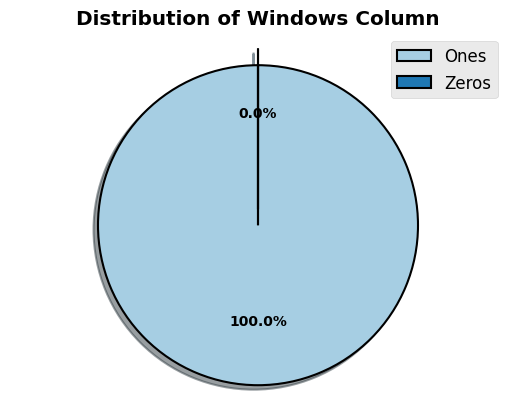

In [46]:
ones_count = df['windows'].sum()
zeros_count = len(df) - ones_count


sizes = [ones_count, zeros_count]
labels = ['Ones', 'Zeros']


explode = (0.1, 0) 
patches, texts, autotexts = plt.pie(
    sizes,
    labels=None, 
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)


plt.legend(patches, labels, loc="best", fontsize='large', frameon=True)
plt.title('Distribution of Windows Column', fontweight='bold')
plt.axis('equal')  
plt.show()
df.drop(columns='windows',inplace=True)

(-1.0999996469807176,
 1.0999999423233724,
 -1.1049725788289066,
 1.2044282449102754)

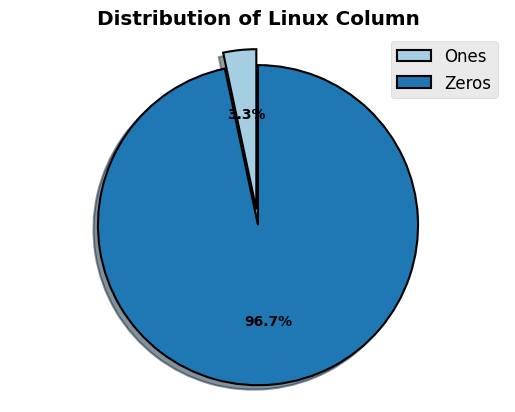

In [47]:
ones_count = df['linux'].sum()
zeros_count = len(df) - ones_count


sizes = [ones_count, zeros_count]
labels = ['Ones', 'Zeros']


explode = (0.1, 0) 
patches, texts, autotexts = plt.pie(
    sizes,
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

plt.legend(patches, labels, loc="best", fontsize='large', frameon=True)
plt.title('Distribution of Linux Column', fontweight='bold')
plt.axis('equal') 

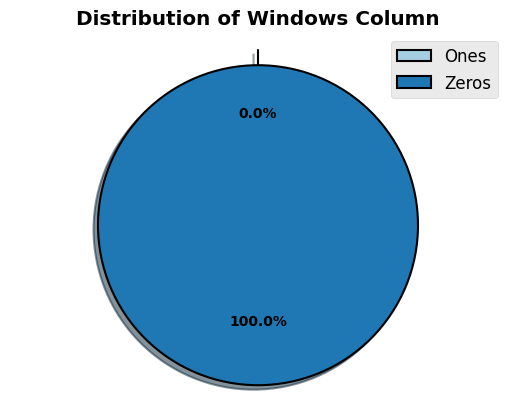

In [48]:
ones_count = df['mac'].sum()
zeros_count = len(df) - ones_count


sizes = [ones_count, zeros_count]
labels = ['Ones', 'Zeros']


explode = (0.1, 0)  
patches, texts, autotexts = plt.pie(
    sizes,
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    textprops={"fontweight": "bold"},
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    colors=plt.cm.Paired.colors
)

# Add a legend instead of labels
plt.legend(patches, labels, loc="best", fontsize='large', frameon=True)
plt.title('Distribution of Windows Column', fontweight='bold')
plt.axis('equal')  # Make it a circle
df.drop(columns='mac',inplace=True)

## Correlation

In [49]:
numeric_columns = df.select_dtypes(include=['number']).columns
print(df.columns)
df_numeric = df[numeric_columns]
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
corr_matrix = df_numeric.corr()
threshold = 0.5
target = 'reviewScore'
if target in corr_matrix.columns:
    
    target_correlations = corr_matrix[target].drop(target).sort_values(key=abs, ascending=False)
    
    target_report = pd.DataFrame({
        'Feature': target_correlations.index,
        'Correlation': target_correlations.values,
        'Absolute_Correlation': target_correlations.abs().values,
        'Significant': target_correlations.abs() >= threshold
    })
    
    print(f"TARGET-ORIENTED FEATURE ANALYSIS (for '{target}')\n")
    print("="*70)
    print(target_report.to_string(index=False))
    
    significant_target_features = target_correlations[target_correlations.abs() >= threshold].index.tolist()
    print(f"Significant features for prediction (|r| ≥ {threshold}):")
    print(significant_target_features)
    print("\n\n")

print("CROSS-FEATURE CORRELATION ANALYSIS")
print("="*70)

significant_corrs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        val = corr_matrix.iloc[i, j]
        if abs(val) >= threshold:
            significant_corrs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': val
            })

results_df = pd.DataFrame(significant_corrs)
results_df['abs_corr'] = results_df['Correlation'].abs()
results_df = results_df.sort_values('abs_corr', ascending=False).drop('abs_corr', axis=1)

print(f"Significant Correlations Between Features (|r| ≥ {threshold}):\n")
print("="*70)
print(results_df.to_string(index=False))

if target in corr_matrix.columns:
    print("FEATURE SELECTION RECOMMENDATIONS\n\n")
    print("="*70)
    print("HIGH-VALUE FEATURES (keep these):\n")
    high_value = target_report[target_report['Significant']].sort_values('Absolute_Correlation', ascending=False)
    print(high_value[['Feature', 'Correlation']].to_string(index=False))
    
    print("LOW-VALUE FEATURES (consider removing):\n")
    low_value = target_report[~target_report['Significant']].sort_values('Absolute_Correlation', ascending=False)
    print(low_value[['Feature', 'Correlation']].to_string(index=False))
    
    redundant_features = set()
    for _, row in results_df.iterrows():
        if target not in [row['Feature 1'], row['Feature 2']]:
            if row['Feature 1'] in high_value['Feature'].values and row['Feature 2'] in high_value['Feature'].values:
                redundant_features.add(row['Feature 2']) 
    
    if redundant_features:
        print("POTENTIALLY REDUNDANT FEATURES (consider removing one of each pair):\n")
        print(list(redundant_features))

print("SUMMARY STATISTICS\n")
print("="*70)
print(f"- Total features analyzed: {len(corr_matrix.columns)}")
if target in corr_matrix.columns:
    print(f"- Features strongly correlated with target ({threshold}+): {len(high_value)}")
    print(f"- Features weakly correlated with target: {len(low_value)}")
print(f"- Significant cross-feature correlations found: {len(results_df)}")

Index([                  'price',              'copiesSold',
            'steam_achievements',     'steam_trading_cards',
              'workshop_support',      'achievements_total',
                   'reviewScore',                    'year',
                         'month',                     'day',
       'publisher_class_encoded',                  'Action',
                 ' Free To Play',                      None,
                     ' Strategy',              ' Adventure',
        ' Massively Multiplayer',                 ' Casual',
                        ' Indie',                 ' Racing',
                          ' RPG',                  'Casual',
                   ' Simulation',               'Adventure',
                           'RPG',                 ' Sports',
                 ' Early Access',                   'Indie',
                      'Strategy',              'Simulation',
         'Massively Multiplayer',                  'Racing',
                  'Free 

## Redundant

In [50]:
df.drop(columns=['Violent', 'Nudity', 'Gore', 'workshop_support', 'Adventure', 'linux'], inplace=True)
print(df.columns)

Index([                  'price',              'copiesSold',
            'steam_achievements',     'steam_trading_cards',
            'achievements_total',             'reviewScore',
                          'year',                   'month',
                           'day', 'publisher_class_encoded',
                        'Action',           ' Free To Play',
                            None,               ' Strategy',
                    ' Adventure',  ' Massively Multiplayer',
                       ' Casual',                  ' Indie',
                       ' Racing',                    ' RPG',
                        'Casual',             ' Simulation',
                           'RPG',                 ' Sports',
                 ' Early Access',                   'Indie',
                      'Strategy',              'Simulation',
         'Massively Multiplayer',                  'Racing',
                  'Free To Play',                   ' Gore',
                       '

## PCA

In [51]:
apply_pca = True  
print("\nChecking for missing values in the selected features:")
print(df.isna().sum())


if 'reviewScore' in df.columns:
    df = df.dropna(subset=['reviewScore'])  
print("\nFilling missing values for categorical columns...")
for col in tqdm(df.columns[df.dtypes == 'object'], desc="Categorical columns", leave=False):
    df[col] = df[col].fillna(df[col].mode()[0])


print("\nFilling missing values for numeric columns...")
for col in tqdm(df.select_dtypes(include=['number']).columns, desc="Numeric columns", leave=False):
    df[col] = df[col].fillna(df[col].mean())


df_selected = df.select_dtypes(include=['number'])  


print("\nTotal NaN after filling missing values:")
print(df_selected.isnull().sum().sum())
df_selected.columns = df_selected.columns.astype(str)


if apply_pca:
    print("\nApplying PCA...")
    pca = PCA(n_components=3)

    
    with tqdm(total=1, desc="PCA fitting", leave=False) as pbar:
        df_pca = pca.fit_transform(df_selected)
        pbar.update(1)

 
    df_pca_df = pd.DataFrame(df_pca, columns=[f'PCA_{i+1}' for i in range(df_pca.shape[1])])


    print("\nVariance Ratio per PCA Component:")
    for i, var_ratio in enumerate(pca.explained_variance_ratio_):
        print(f"PCA_{i+1}: {var_ratio:.4f}")

   
    feature_loadings = pd.DataFrame(
        pca.components_.T,  
        columns=[f'PCA_{i+1}' for i in range(pca.n_components_)],
        index=df_selected.columns
    )
abs_loadings = abs(df.corr())
pca_top_3_features = abs_loadings.sum(axis=1).nlargest(3).index.tolist()


if 'reviewScore' in pca_top_3_features:
    pca_top_3_features.remove('reviewScore')


if len(pca_top_3_features) < 3:
    additional_feature = abs_loadings.sum(axis=1).nlargest(3 + len(pca_top_3_features)).index[-1]
    pca_top_3_features.append(additional_feature)


print("Top 3 features PCA selected: ", pca_top_3_features)


Checking for missing values in the selected features:
price                      2
copiesSold                 2
steam_achievements         2
steam_trading_cards        2
achievements_total         0
reviewScore                0
year                       0
month                      0
day                        0
publisher_class_encoded    0
Action                     0
 Free To Play              0
None                       0
 Strategy                  0
 Adventure                 0
 Massively Multiplayer     0
 Casual                    0
 Indie                     0
 Racing                    0
 RPG                       0
Casual                     0
 Simulation                0
RPG                        0
 Sports                    0
 Early Access              0
Indie                      0
Strategy                   0
Simulation                 0
Massively Multiplayer      0
Racing                     0
Free To Play               0
 Gore                      0
 Action          

Categorical columns: 0it [00:00, ?it/s]


Filling missing values for numeric columns...


Numeric columns:   0%|          | 0/54 [00:00<?, ?it/s]


Total NaN after filling missing values:
0

Applying PCA...


PCA fitting:   0%|          | 0/1 [00:00<?, ?it/s]


Variance Ratio per PCA Component:
PCA_1: 0.5232
PCA_2: 0.3205
PCA_3: 0.1145
Top 3 features PCA selected:  ['Total_Genres', 'Action', ' Indie']


## Recursive Feature Elimination (RFE)

In [52]:
X = df.select_dtypes(include=['number']) 
y = df['reviewScore']

X.columns = X.columns.astype(str)  

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

model = RandomForestRegressor(random_state=42)
selector = RFE(estimator=model, n_features_to_select=5)


with tqdm(total=1, desc="RFE Feature Selection Progress", unit="step") as pbar:
    selector.fit(X_imputed, y)  
    pbar.update(1)  


rfe_selected_features = X.columns[selector.support_]
print(f"Top 5 features selected by RFE: {rfe_selected_features}")

RFE Feature Selection Progress:   0%|          | 0/1 [00:00<?, ?step/s]

Top 5 features selected by RFE: Index(['price', 'copiesSold', 'reviewScore', 'month', 'day'], dtype='object')


In [53]:
final_df = df[['Total_Genres', 'Action',' Indie','copiesSold', 'year', 'reviewScore']]
final_df.to_csv('/kaggle/working/preprocessed.csv', index=False)

# Data Splitting

In [54]:
X = df[['Total_Genres', 'Action',' Indie','copiesSold', 'year', ' Sports']]
X = X.fillna(X.median())
y = df['reviewScore'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ML Models

## XGBoost

XGBoost MSE: 284.5124050075248
XGBoost MAE: 13.201991915040102
XGBoost R²: 0.22046507912846747


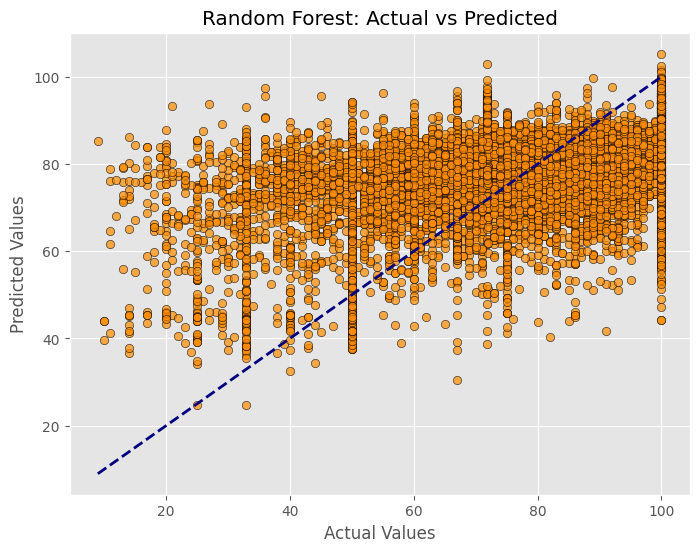

In [55]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost R²: {r2_xgb}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, color='darkorange', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='navy', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True)
plt.show()

## Random Forest

Random Forest MSE: 329.8264
Random Forest MAE: 13.7472
Random Forest R²: 0.0963


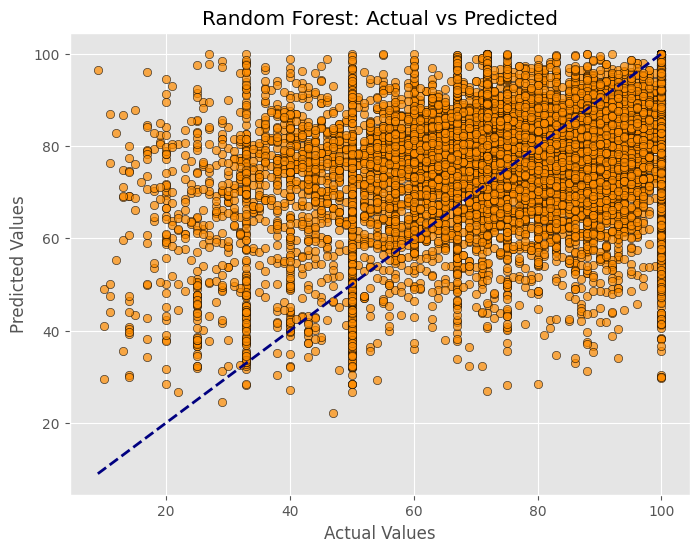

In [56]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Random Forest MAE: {mae_rf:.4f}")
print(f"Random Forest R²: {r2_rf:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, color='darkorange', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='navy', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True)
plt.show()


## Multilayer Perceptron (MLP) Regressor

MLP MSE: 361.7431
MLP MAE: 15.0621
MLP R²: 0.0089


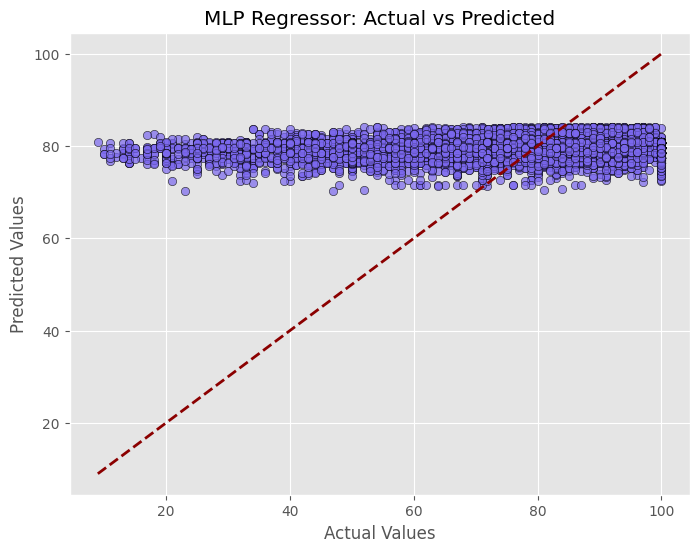

In [57]:
mlp_model = MLPRegressor(random_state=42)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

mse_mlp = mean_squared_error(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP MSE: {mse_mlp:.4f}")
print(f"MLP MAE: {mae_mlp:.4f}")
print(f"MLP R²: {r2_mlp:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_mlp, color='mediumslateblue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='darkred', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('MLP Regressor: Actual vs Predicted')
plt.grid(True)
plt.show()

## KNN Regressor

KNN MSE: 353.7301619597477
KNN MAE: 14.459241286417868
R² KNN: 0.03081549711031606


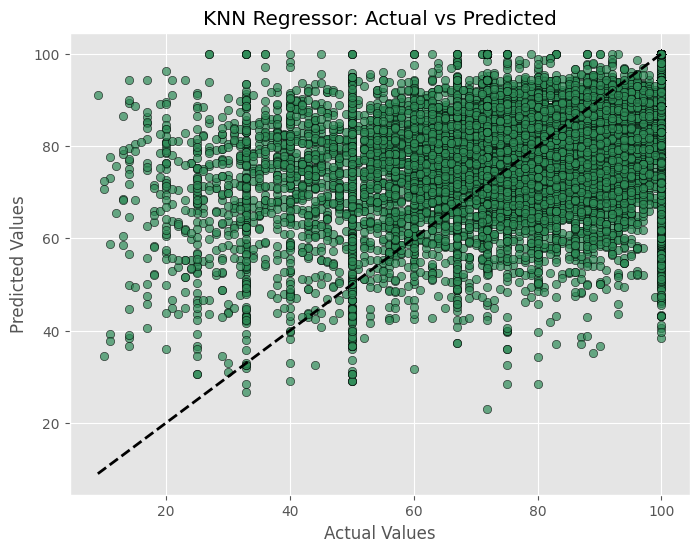

In [58]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2 = r2_score(y_test, y_pred_knn)
print(f"KNN MSE: {mse_knn}")
print(f"KNN MAE: {mae_knn}")
print(f"R² KNN: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_knn, color='seagreen', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('KNN Regressor: Actual vs Predicted')
plt.grid(True)
plt.show()

## Polynomial Regression

Polynomial Regression MSE: 335.9439446633928
Polynomial Regression MAE: 335.9439446633928
R²: 0.0795479152709625


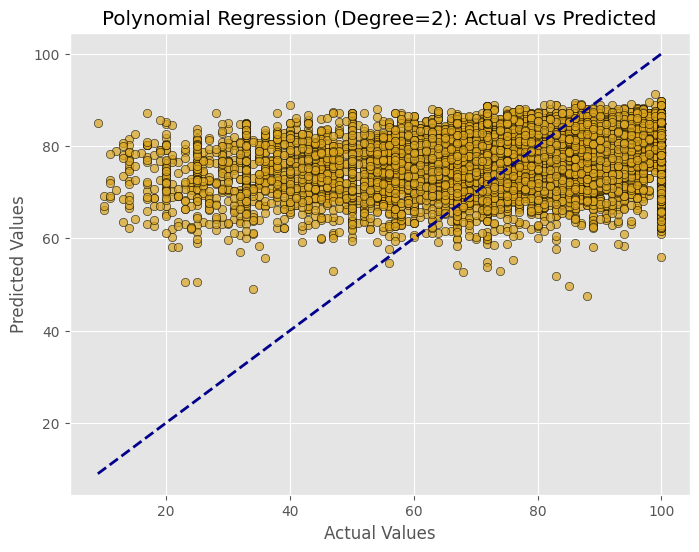

In [59]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
X_test_poly = poly.transform(X_test)
y_pred_poly = poly_model.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
mae_poly = mean_squared_error(y_test, y_pred_poly)
r2 = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression MSE: {mse_poly}")
print(f"Polynomial Regression MAE: {mae_poly}")
print(f"R²: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_poly, color='goldenrod', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='darkblue', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Polynomial Regression (Degree=2): Actual vs Predicted')
plt.grid(True)
plt.show()

## Lasso Regression

Lasso MSE: 346.92990135836146
Lasso MAE: 14.992988569648968
R²: 0.049447516370310196


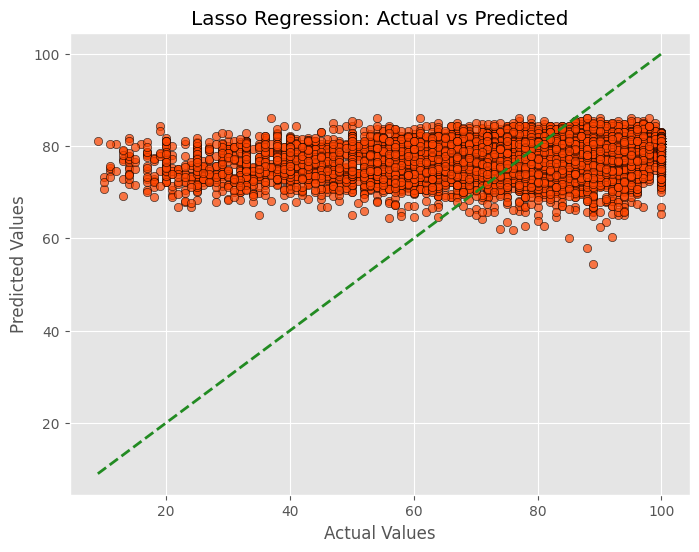

In [60]:
lasso_model = Lasso(random_state=42)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2 = r2_score(y_test, y_pred_lasso)
print(f"Lasso MSE: {mse_lasso}")
print(f"Lasso MAE: {mae_lasso}")
print(f"R²: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, color='orangered', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='forestgreen', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Lasso Regression: Actual vs Predicted')
plt.grid(True)
plt.show()

## Ridge

Ridge MSE: 341.07986206533633
Ridge MAE: 14.800103201686708
R²: 0.06547602633022953


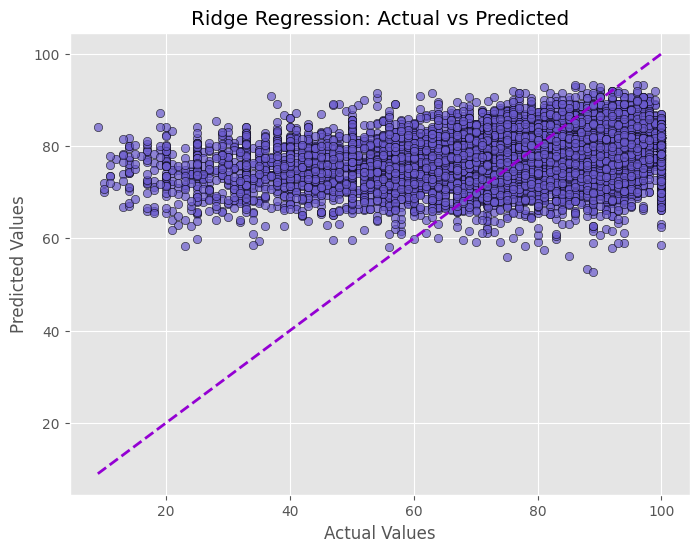

In [61]:
ridge_model = Ridge(random_state=42)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2 = r2_score(y_test, y_pred_ridge)
print(f"Ridge MSE: {mse_ridge}")
print(f"Ridge MAE: {mae_ridge}")
print(f"R²: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, color='slateblue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='darkviolet', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ridge Regression: Actual vs Predicted')
plt.grid(True)
plt.show()

## Decsion Trees

Decision Tree MSE: 448.51560310565276
Decision Tree MAE: 15.449675092446904
R²: -0.22888692732875948


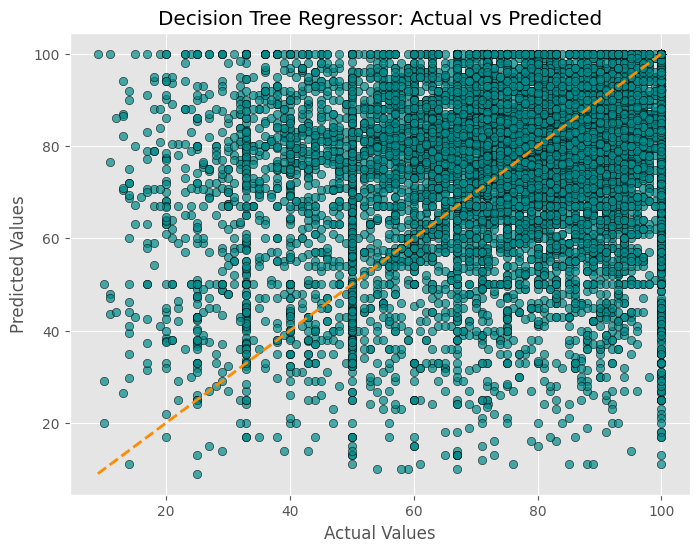

In [62]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)

r2_tree = r2_score(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse_tree}")
print(f"Decision Tree MAE: {mae_tree}")
print(f"R²: {r2_tree}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tree, color='darkcyan', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='darkorange', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Regressor: Actual vs Predicted')
plt.grid(True)
plt.show()

Linear Regression MSE: 341.0799073484126
Linear Regression MAE: 14.800099085806263
Linear Regression R²: 0.06547590225922717


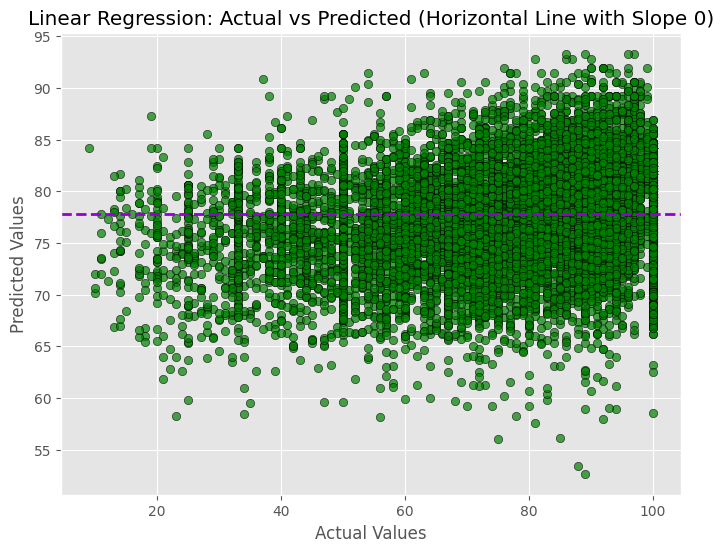

In [63]:
linear_model = LinearRegression(fit_intercept=True)  
linear_model.fit(X_train, y_train)

y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression MSE: {mse_linear}")
print(f"Linear Regression MAE: {mae_linear}")
print(f"Linear Regression R²: {r2_linear}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, color='green', edgecolor='k', alpha=0.7)
plt.axhline(y=y_pred_linear.mean(), color='darkviolet', linestyle='--', linewidth=2)  
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted (Horizontal Line with Slope 0)')
plt.grid(True)
plt.show()